# 2D Poisson's ratio deterministic adjoint-based inversion: role of earthquake depth

This notebook contains several deterministic adjoint-based inversion of the surface geodetic data for the heterogeneous Poisson's ratio structure, assuming the knowledge of the fault slip distribution, as a function of the depth of the earthquake.


In [1]:
# Import libraries
import dolfin as dl
import ufl
import pandas as pd
import math
import numpy as np
# Import libraries for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.tri as tri
from matplotlib.patches import Polygon
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif', size=16)
rc('legend', fontsize=16)
TINY_SIZE = 14
SMALL_SIZE = 20
MEDIUM_SIZE = 30
BIGGER_SIZE = 40
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

import sys, os
#sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "...") )
import hippylib as hp
# Load TV regularization class and observation operator
from pointwiseStateObs import PointwiseStateObservation
from TVprior import *

# Make results reproducible
np.random.seed(seed=1)

# Set parameters compiler
dl.parameters["form_compiler"]["quadrature_degree"] = 5
dl.parameters["form_compiler"]["optimize"] = True
# Mute FFC and UFL warnings
import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)


In [2]:
# Define functions
# Define the compliance matrix for elasticity
def AEsigma(s, mu, nu):
    A = 1./(2.*mu)*( s - nu/( 1 + nu*(dim-2) )*ufl.tr(s)*ufl.Identity(dim) )
    return A

# Define the asymmetry operator
def asym(s): 
    as_ = s[0,1] - s[1,0]
    return as_

# Define the tangent operator
def T(n):
    T_operator = ufl.as_vector( [n[1], -n[0]] )
    return T_operator

# Class to define different properties in the subdomains with anomaly built-in
class K_Triangle(dl.UserExpression):
    def __init__(self, subdomains, k_0, k_1, **kwargs):
        super().__init__(**kwargs)
        self.subdomains = subdomains
        self.k_0 = k_0
        self.k_1 = k_1

    def eval_cell(self, values, x, cell):
        if self.subdomains[cell.index] == triangle_surface:
            values[0] = self.k_0
        else:
            values[0] = self.k_1

    def value_shape(self):
        return ()
        

In [3]:
# Mesh
path = "../Mesh/"
name = "Mesh_CurvedFault_Triangle_PaperII"
mesh = dl.Mesh(path + name + '.xml')
xmin = -700.; xmax = 400.; ymin = -500.; ymax = 0.
# Extract dimension of the mesh
dim = mesh.topology().dim()
# Define normal component to boundaries
n = dl.FacetNormal(mesh)
# Define boundaries
boundaries = dl.MeshFunction("size_t", mesh, path + name + '_facet_region.xml')
subdomains = dl.MeshFunction("size_t", mesh, path + name + '_physical_region.xml')
top = 1
left = 2
bottom = 3
right = 4
fault = 5
blockleft = 7
blockright = 8
triangle = 9
triangle_surface = 10
ds = dl.Measure('ds')(domain=mesh, subdomain_data=boundaries)
dS = dl.Measure('dS')(domain=mesh, subdomain_data=boundaries)

# Define sep
sep = "\n"+"#"*80+"\n"


In [4]:
# Create function to interpolate in a region of interest (small portion of the domain)
def get_dx_for_error_evaluation(mesh, xmin, xmax, ymin, ymax):
    class LimitedDomain(dl.SubDomain):
        def inside(self, x, on_boundary):
            x_range = dl.between(x[0], (xmin, xmax))
            y_range = dl.between(x[1], (ymin, ymax))
            return x_range and y_range
    
    # Marker the subdomain
    marker_errors = dl.MeshFunction("size_t", mesh, dim)
    aroundFaultEdges = LimitedDomain()
    marker_errors.set_all(20)
    aroundFaultEdges.mark(marker_errors, 21)
    my_dx = dl.Measure("dx", domain=mesh, subdomain_data=marker_errors)
    
    return my_dx(21)
    

In [5]:
# The linear coseismic inversion problem
# Define the weak formulation of the FORWARD problem
def pde_varf(u, m, p):
    # Split the STATE and ADJOINT variables. Use dl.split() and not
    # .split(deepcopy=True), since the latter breaks FEniCS symbolic differentiation
    sigma, uu, r = dl.split(u)
    tau, w, q = dl.split(p)
    u0 = dl.Constant((0., 0.))
    # Define the weak formulation of the forward problem
    nu_expr = 0.25*(1. + ufl.tanh(m))
    J = ufl.inner( AEsigma(sigma, mu, nu_expr), tau )*ufl.dx \
        + ufl.inner( ufl.div(tau), uu )*ufl.dx \
        + ufl.inner( asym(tau), r )*ufl.dx \
        + ufl.inner( ufl.div(sigma), w )*ufl.dx + ufl.inner( asym(sigma), q )*ufl.dx \
        + ufl.inner( f, w )*ufl.dx \
        - ufl.inner( u0, tau*n )*ds(bottom) \
        - ufl.inner( ufl.avg(slip), ufl.dot(  T(n('+')), tau('+')*n('+') ) )*dS(fault)
    return J
    

In [6]:
# Create a function that solve the Poisson's ratio deterministic adjoint-based inversion
def solveInverseProblem(k, targets, slip, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps, verbose=True):
    
    # Define function spaces
    # Use VectorFunctionSpace if the unknown is a vector field.
    # Use FunctionSpace object for scalar fields.
    BDM = dl.VectorFunctionSpace(mesh, "BDM", k)    # stress (tensor field, since BDM is a vector field)
    DGv = dl.VectorFunctionSpace(mesh, "DG", k-1)   # displacement (vector field)
    DGr = dl.FunctionSpace(mesh, "DG", k-1)         # rotation (scalar field)
    ME_element = dl.MixedElement([BDM.ufl_element(), DGv.ufl_element(), DGr.ufl_element()])
    Vu = dl.FunctionSpace(mesh, ME_element)
    n = dl.FacetNormal(mesh)
    # Define function space for the model parameter (scalar), which is continuous
    Vm = dl.FunctionSpace(mesh, "CG", 1)
    # Combine the STATE, PARAMETER and ADJOINT function spaces
    Vh = [Vu, Vm, Vu]
    # Print the dofs of STATE, PARAMETER and ADJOINT variables
    ndofs = [ Vh[hp.STATE].dim(), Vh[hp.PARAMETER].dim(), Vh[hp.ADJOINT].dim() ]
    ndofs_state = [ Vu.sub(0).dim(), Vu.sub(1).dim(), Vu.sub(2).dim() ]
    if verbose:
        print( sep, "Set up the mesh and finite element spaces", sep )
        print( "Number of dofs: STATE={0}, PARAMETER={1}, ADJOINT={2}".format(*ndofs) )
        print( "Number of STATE and ADJOINT dofs: STRESS={0}, DISPLACEMENT={1}, ROTATION={2}".format(*ndofs_state) )

    # Define the STATE and ADJOINT Dirichlet BCs
    zero_tensor = dl.Expression( (("0.", "0."), ("0.", "0.")), degree=5 )
    bc = dl.DirichletBC(Vh[hp.STATE].sub(0), zero_tensor, boundaries, top)
    bc0 = dl.DirichletBC(Vh[hp.STATE].sub(0), zero_tensor, boundaries, top)

    # Define the PDE problem
    pde = hp.PDEVariationalProblem(Vh, pde_varf, bc, bc0, is_fwd_linear=True)

    # Print the number of observations (observed surface horizontal and vertical displacements)
    if verbose:
        print( "Number of observation points: {0}".format(targets.shape[0]) )
    # Define the Misfit function to calculate the data misfit
    misfit = PointwiseStateObservation(Vh[hp.STATE], targets, indicator_vec=dl.interpolate(dl.Constant((0,0,0,0,1,1,0)), Vh[hp.STATE]).vector())
    # Define the regularization component
    reg_handler = vectorTVH1L2handler(gamma_val_TV, gamma_val_H1, delta_val_L2, eps=eps)
    reg = NonGaussian_Prior(Vh[hp.PARAMETER], reg_handler)
    
    # Define the true model PARAMETER
    mtrue = dl.interpolate(mtrue_expr, Vh[hp.PARAMETER]).vector()
    # Define the starting model (initial guess) 'm_0'
    m0 = dl.interpolate(m0_expr, Vh[hp.PARAMETER]).vector()

    # Solve FORWARD problem for the STATE variables & generate synthetic observations
    utrue = pde.generate_state() # all dofs STATE variables and PETSC vector (not FEniCS Function)
    x = [utrue, mtrue, None]
    pde.solveFwd(x[hp.STATE], x)
    # Generate true observations by using the observation operator 'B'
    misfit.B.mult(x[hp.STATE], misfit.d)
        
    # Pollute true observations with random noise and generate synthetic data
    MAX = misfit.d.norm("linf") 
    hp.Random().normal_perturb(noise_std_dev, misfit.d) # Comment if no data noise
    misfit.noise_variance = noise_std_dev*noise_std_dev
    print( "The MAX displacement (m) is: %.4f and standard deviation of the noise (m) is: %.6f" %(MAX, noise_std_dev) )
    print( "Noise variance = {0}".format(noise_std_dev*noise_std_dev) )

    # Extract x,y coordinates of the fault for plotting
    bc1 = dl.DirichletBC(Vm, 10, boundaries, fault)
    um = dl.Function(Vm)
    bc1.apply(um.vector())
    # Extract x,y coordinates of the fault and values
    xslip = dl.interpolate(dl.Expression("x[0]", degree=5), Vm)
    yslip = dl.interpolate(dl.Expression("x[1]", degree=5), Vm)
    xf = xslip.vector()[um.vector() == 10] # x coordinate fault
    yf = yslip.vector()[um.vector() == 10] # y coordinate fault
    # Sort the values
    idx = np.argsort(xf)
    xf = xf[idx]; yf = yf[idx]
    
    # Construct the "Model" --> objective function
    model = hp.Model(pde, reg, misfit)

    if verbose:
        print( sep, "Solve the deterministic inverse problem", sep)
    m = reg.mean.copy()
    parameters = hp.ReducedSpaceNewtonCG_ParameterList()
    parameters["rel_tolerance"] = 1e-12 
    parameters["abs_tolerance"] = 1e-9 
    parameters["max_iter"]      = 100 
    parameters["globalization"] = "LS"
    parameters["LS"]["c_armijo"] = 1e-5 
    parameters["GN_iter"] = 5
    if verbose == False:
        parameters["print_level"] = -1

    if verbose:
        parameters.showMe()
    solver = hp.ReducedSpaceNewtonCG(model, parameters)
    # Create a vector containig the solution of the inverse problem (MAP point)
    x = solver.solve([None, m, None])
    # Print solver convergence
    if verbose:
        if solver.converged:
            print( "\nConverged in ", solver.it, " iterations.")
        else:
            print( "\nNot Converged")

        print ("Termination reason: ", solver.termination_reasons[solver.reason])
        print ("Final gradient norm: ", solver.final_grad_norm)
        print ("Final cost: ", solver.final_cost)

    # Convert from m to Poisson's ratio
    mtrue_fun = hp.vector2Function(mtrue, Vh[hp.PARAMETER])
    poisson_true = dl.project(dl.Constant(0.25)*(dl.Constant(1.) + ufl.tanh(mtrue_fun)), Vh[hp.PARAMETER] )
    m_fun = hp.vector2Function(m, Vh[hp.PARAMETER])
    poisson = dl.project(dl.Constant(0.25)*(dl.Constant(1.) + ufl.tanh(m_fun)), Vh[hp.PARAMETER] )
    # Print the range of the MAP point
    if verbose:
        print( min(poisson.vector()[:]), max(poisson.vector()[:]) )

    # Calculate relative error in the domain
    lef, rig, bot, topp = -200., 100., -150., 0.
    my_dx = get_dx_for_error_evaluation(mesh, lef, rig, bot, topp)
    # Absolute L1-norm
    #rel_error = dl.assemble( abs(poisson_true-poisson)*my_dx ) 
    # Relative L2-norm
    rel_error = dl.sqrt( dl.assemble( dl.inner(poisson_true-poisson, poisson_true-poisson)*my_dx ) / dl.assemble( dl.inner(poisson_true, poisson_true)*my_dx ) ) * 100
    if verbose:
        print( "The relative error is: %.1f per cent" %rel_error )
        
        
    # Look spectum Hessian misfit generalized eigenproblem
    model.setPointForHessianEvaluations(x, gauss_newton_approx=False)
    Hmisfit = hp.ReducedHessian(model, misfit_only=True)
    k_evec = 80
    p_evec = 20
    if verbose:
        print( "Single/Double Pass Algorithm. Requested eigenvectors: {0}; Oversampling {1}".format(k_evec, p_evec) )
    Omega = hp.MultiVector(x[hp.PARAMETER], k_evec+p_evec)
    hp.Random().normal(1., Omega)
    # Consider also the mass matrix for the generalized eigenproblem
    trial = dl.TrialFunction(Vh[hp.PARAMETER])
    test = dl.TestFunction(Vh[hp.PARAMETER])
    Mvarf = ufl.inner(trial, test)*ufl.dx
    M = dl.assemble(Mvarf, keep_diagonal=True)
    M.ident_zeros()
    M_solver = hp.PETScKrylovSolver(Vh[hp.PARAMETER].mesh().mpi_comm(), "cg", "jacobi")
    M_solver.set_operator(M) # reg.Msolver
    # Solve the eigenvalue problem: H_misfit v = lambda M_i v
    #lmbda, V = hp.doublePassG(Hmisfit, M, M_solver, Omega, k_evec)
    lmbda, V = hp.doublePass(Hmisfit, Omega, k_evec, s=1)
    lmbda_R, V_R = hp.doublePassG(Hmisfit, reg.R, reg.Rsolver, Omega, k_evec)
    
        
    return( mesh, Vh, targets, xf, yf, utrue, poisson_true, poisson, rel_error, lmbda, lmbda_R, noise_std_dev )
    

In [7]:
### DEFINE COMMON PARAMETERS ###
# Define order of elements (k = 1 --> linear; k = 2 --> quadratic)
k = 1
# Define body force
f = dl.Constant((0., 0.))
# Define the true model PARAMETER
mu = 30e9         # Young's modulus
nu_b = -0.2      # background Poisson's ratio
nu_background = 0.25*(1.+np.tanh(nu_b))
nu_i = 0.425     # anomaly Poisson's ratio
nu_anomaly = 0.25*(1.+np.tanh(nu_i))
print( "The Poisson's ratio for the anomaly is: nu = %.2f while the background nu = %.2f" %(nu_anomaly, nu_background) )
mtrue_expr = K_Triangle(subdomains, nu_i, nu_b, degree=0)
# Define the expression for starting model
m0_expr = dl.Constant(0.0)


The Poisson's ratio for the anomaly is: nu = 0.35 while the background nu = 0.20


In [8]:
# Define the axes range
lef, rig, topp, bot = -200., 100., 0., -150.

# Define colormaps and level for contourf
cmap_1 = plt.get_cmap("Blues")
cmap_2 = plt.get_cmap("viridis", 21)
cmap_3 = plt.get_cmap("RdBu_r")
cmap_4 = plt.get_cmap("RdBu_r", 21)
levels_ux = np.linspace(-4., 4., 21)
levels_uy = np.linspace(-4., 4., 21)
levels_m = np.linspace(nu_background-1e-5, nu_anomaly+1e-3, 21)
colors = [ cmap_1(0.3), cmap_1(0.6), cmap_1(0.9) ]
# Create the perimeter of the triangular anomaly
xy_triangle = np.array([ [-160.0,-5.0], [-30.0,-5.0], [-95.0, -55.0] ]) 

# For labels of subplots (a,b,c,d)
props = dict(boxstyle='round', lw=0.25, facecolor='ivory', alpha=0.95)


In [9]:
# Generate random surface observations
ntargets = 20
targets_x = np.linspace(-180., 0., ntargets) 
targets_y = (ymax-dl.DOLFIN_EPS)*np.ones(ntargets)
targets = np.zeros([ntargets, dim])
targets[:,0] = targets_x; targets[:,1] = targets_y

# Choose data noise
noise_std_dev = 0.002
EQ_std = 15.


In [10]:
# EQ: 5 km
slip = dl.Expression(('u0*exp(-(pow((x[1]-xc),2)/(pow(std,2))))'), u0=-10., xc=-5., std=EQ_std, degree=5)

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1 
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3 

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue_1, mtrue, m_1, rel_error_1, lmbda_1, lmbda_R_1, noise_std_dev_1 ) = solveInverseProblem(k, targets, slip, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 6.1939 and standard deviation of the noise (m) is: 0.002000
Noise variance = 4e-06

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (1e-05): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtracking it

In [11]:
# EQ: 10 km
slip = dl.Expression(('u0*exp(-(pow((x[1]-xc),2)/(pow(std,2))))'), u0=-10., xc=-10., std=EQ_std, degree=5)

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1 
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3 

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue_2, mtrue, m_2, rel_error_2, lmbda_2, lmbda_R_2, noise_std_dev_2 ) = solveInverseProblem(k, targets, slip, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 4.9954 and standard deviation of the noise (m) is: 0.002000
Noise variance = 4e-06

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (1e-05): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtracking it

In [12]:
# EQ: 15 km
slip = dl.Expression(('u0*exp(-(pow((x[1]-xc),2)/(pow(std,2))))'), u0=-10., xc=-15., std=EQ_std, degree=5)

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1 
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue_3, mtrue, m_3, rel_error_3, lmbda_3, lmbda_R_3, noise_std_dev_3 ) = solveInverseProblem(k, targets, slip, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 3.7735 and standard deviation of the noise (m) is: 0.002000
Noise variance = 4e-06

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (1e-05): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtracking it

In [27]:
# EQ: 20 km
slip = dl.Expression(('u0*exp(-(pow((x[1]-xc),2)/(pow(std,2))))'), u0=-10., xc=-20., std=EQ_std, degree=5)

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1 
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3 

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue_4, mtrue, m_4, rel_error_4, lmbda_4, lmbda_R_4, noise_std_dev_4 ) = solveInverseProblem(k, targets, slip, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 2.6328 and standard deviation of the noise (m) is: 0.002000
Noise variance = 4e-06

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (1e-05): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtracking it

Single/Double Pass Algorithm. Requested eigenvectors: 80; Oversampling 20


In [14]:
# EQ: 25 km
slip = dl.Expression(('u0*exp(-(pow((x[1]-xc),2)/(pow(std,2))))'), u0=-10., xc=-25., std=EQ_std, degree=5)

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1 
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue_5, mtrue, m_5, rel_error_5, lmbda_5, lmbda_R_5, noise_std_dev_5 ) = solveInverseProblem(k, targets, slip, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 2.7362 and standard deviation of the noise (m) is: 0.002000
Noise variance = 4e-06

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (1e-05): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtracking it

In [39]:
# EQ: 30 km
slip = dl.Expression(('u0*exp(-(pow((x[1]-xc),2)/(pow(std,2))))'), u0=-10., xc=-30., std=EQ_std, degree=5)

# Define regularization weights
eps = 1e-7
gamma_val_TV = 1.7e-1 
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue_6, mtrue, m_6, rel_error_6, lmbda_6, lmbda_R_6, noise_std_dev_6 ) = solveInverseProblem(k, targets, slip, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 2.7602 and standard deviation of the noise (m) is: 0.002000
Noise variance = 4e-06

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (1e-05): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtracking it

 55  54    1.139947e+02    5.710541e+01    5.688934e+01   -5.612879e-05   1.581452e-02   1.000000e+00   1.610167e-03
 56  60    1.139947e+02    5.710537e+01    5.688938e+01   -1.699161e-06   2.457216e-03   1.000000e+00   6.346944e-04
 57  72    1.139947e+02    5.710537e+01    5.688938e+01   -1.541863e-09   7.715870e-05   1.000000e+00   1.124697e-04
 58  77    1.139947e+02    5.710537e+01    5.688938e+01   -1.362589e-15   7.949446e-08   6.250000e-02   3.610035e-06
 59  81    1.139947e+02    5.710537e+01    5.688938e+01   -1.197616e-15   7.447974e-08   7.812500e-03   3.494315e-06
 60  81    1.139947e+02    5.710537e+01    5.688938e+01   -1.179897e-15   7.677958e-08   1.562500e-02   3.547855e-06
 61  76    1.139947e+02    5.710537e+01    5.688938e+01   -1.142056e-15   7.309430e-08   9.765625e-04   3.461663e-06

Not Converged
Termination reason:  Maximum number of backtracking reached
Final gradient norm:  7.309430173321238e-08
Final cost:  113.99474728785285
0.13394582036735342 0.35862251

In [16]:
# EQ: 35 km
slip = dl.Expression(('u0*exp(-(pow((x[1]-xc),2)/(pow(std,2))))'), u0=-10., xc=-35., std=EQ_std, degree=5)

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1 
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3 

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue_7, mtrue, m_7, rel_error_7, lmbda_7, lmbda_R_7, noise_std_dev_7 ) = solveInverseProblem(k, targets, slip, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 2.6499 and standard deviation of the noise (m) is: 0.002000
Noise variance = 4e-06

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (1e-05): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtracking it

In [17]:
# EQ: 40 km
slip = dl.Expression(('u0*exp(-(pow((x[1]-xc),2)/(pow(std,2))))'), u0=-10., xc=-40., std=EQ_std, degree=5)

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1 
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3 

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue_8, mtrue, m_8, rel_error_8, lmbda_8, lmbda_R_8, noise_std_dev_8 ) = solveInverseProblem(k, targets, slip, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 2.4556 and standard deviation of the noise (m) is: 0.002000
Noise variance = 4e-06

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (1e-05): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtracking it

In [33]:
# EQ: 45 km
slip = dl.Expression(('u0*exp(-(pow((x[1]-xc),2)/(pow(std,2))))'), u0=-10., xc=-45., std=EQ_std, degree=5)

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1 
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3 

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue_9, mtrue, m_9, rel_error_9, lmbda_9, lmbda_R_9, noise_std_dev_9 ) = solveInverseProblem(k, targets, slip, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 2.2458 and standard deviation of the noise (m) is: 0.002000
Noise variance = 4e-06

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (1e-05): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtracking it

In [19]:
# EQ: 50 km
slip = dl.Expression(('u0*exp(-(pow((x[1]-xc),2)/(pow(std,2))))'), u0=-10., xc=-50., std=EQ_std, degree=5)

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3 

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue_10, mtrue, m_10, rel_error_10, lmbda_10, lmbda_R_10, noise_std_dev_10 ) = solveInverseProblem(k, targets, slip, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 1.9828 and standard deviation of the noise (m) is: 0.002000
Noise variance = 4e-06

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (1e-05): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtracking it

In [20]:
# EQ: 55 km
slip = dl.Expression(('u0*exp(-(pow((x[1]-xc),2)/(pow(std,2))))'), u0=-10., xc=-55., std=EQ_std, degree=5)

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1 
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3 

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue_11, mtrue, m_11, rel_error_11, lmbda_11, lmbda_R_11, noise_std_dev_11 ) = solveInverseProblem(k, targets, slip, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 1.5862 and standard deviation of the noise (m) is: 0.002000
Noise variance = 4e-06

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (1e-05): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtracking it

In [21]:
# EQ: 60 km
slip = dl.Expression(('u0*exp(-(pow((x[1]-xc),2)/(pow(std,2))))'), u0=-10., xc=-60., std=EQ_std, degree=5)

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1 
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3 

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue_12, mtrue, m_12, rel_error_12, lmbda_12, lmbda_R_12, noise_std_dev_12 ) = solveInverseProblem(k, targets, slip, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 1.1685 and standard deviation of the noise (m) is: 0.002000
Noise variance = 4e-06

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (1e-05): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtracking it

## Combine all results for plotting

In [40]:
# Compute the metric LDPDH, which is the log-determinant of the pre-conditioned data misfit Hessian 
lmbda_0 = 1e0
LDPDH_1 = 0.5*np.sum( np.log(1.+lmbda_1[(lmbda_1 > lmbda_0)] ) )
LDPDH_2 = 0.5*np.sum( np.log(1.+lmbda_2[(lmbda_2 > lmbda_0)] ) )
LDPDH_3 = 0.5*np.sum( np.log(1.+lmbda_3[(lmbda_3 > lmbda_0)] ) )
LDPDH_4 = 0.5*np.sum( np.log(1.+lmbda_4[(lmbda_4 > lmbda_0)] ) )
LDPDH_5 = 0.5*np.sum( np.log(1.+lmbda_5[(lmbda_5 > lmbda_0)] ) )
LDPDH_6 = 0.5*np.sum( np.log(1.+lmbda_6[(lmbda_6 > lmbda_0)] ) )
LDPDH_7 = 0.5*np.sum( np.log(1.+lmbda_7[(lmbda_7 > lmbda_0)] ) )
LDPDH_8 = 0.5*np.sum( np.log(1.+lmbda_8[(lmbda_8 > lmbda_0)] ) )
LDPDH_9 = 0.5*np.sum( np.log(1.+lmbda_9[(lmbda_9 > lmbda_0)] ) )
LDPDH_10 = 0.5*np.sum( np.log(1.+lmbda_10[(lmbda_10 > lmbda_0)] ) )
LDPDH_11 = 0.5*np.sum( np.log(1.+lmbda_11[(lmbda_11 > lmbda_0)] ) )
LDPDH_12 = 0.5*np.sum( np.log(1.+lmbda_12[(lmbda_12 > lmbda_0)] ) )

EQ_depths = np.array([ 5, 10, 15, 20, 25,
                      30, 35, 40, 45, 50,
                      55, 60 ])

LDPDH = np.array([ LDPDH_1, LDPDH_2, LDPDH_3, LDPDH_4, LDPDH_5,
                   LDPDH_6, LDPDH_7, LDPDH_8, LDPDH_9, LDPDH_10,
                   LDPDH_11, LDPDH_12 ])

ms = np.array([ m_1, m_2, m_3, m_4, m_5, 
                m_6, m_7, m_8, m_9, m_10,
                m_11, m_12 ])

lmbda_all = np.array([ lmbda_1, lmbda_2, lmbda_3, lmbda_4, lmbda_5, 
                       lmbda_6, lmbda_7, lmbda_8, lmbda_9, lmbda_10, 
                       lmbda_11, lmbda_12 ])

i_lmbda_all = np.arange(1, len(lmbda_1)+1)


## Plot

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


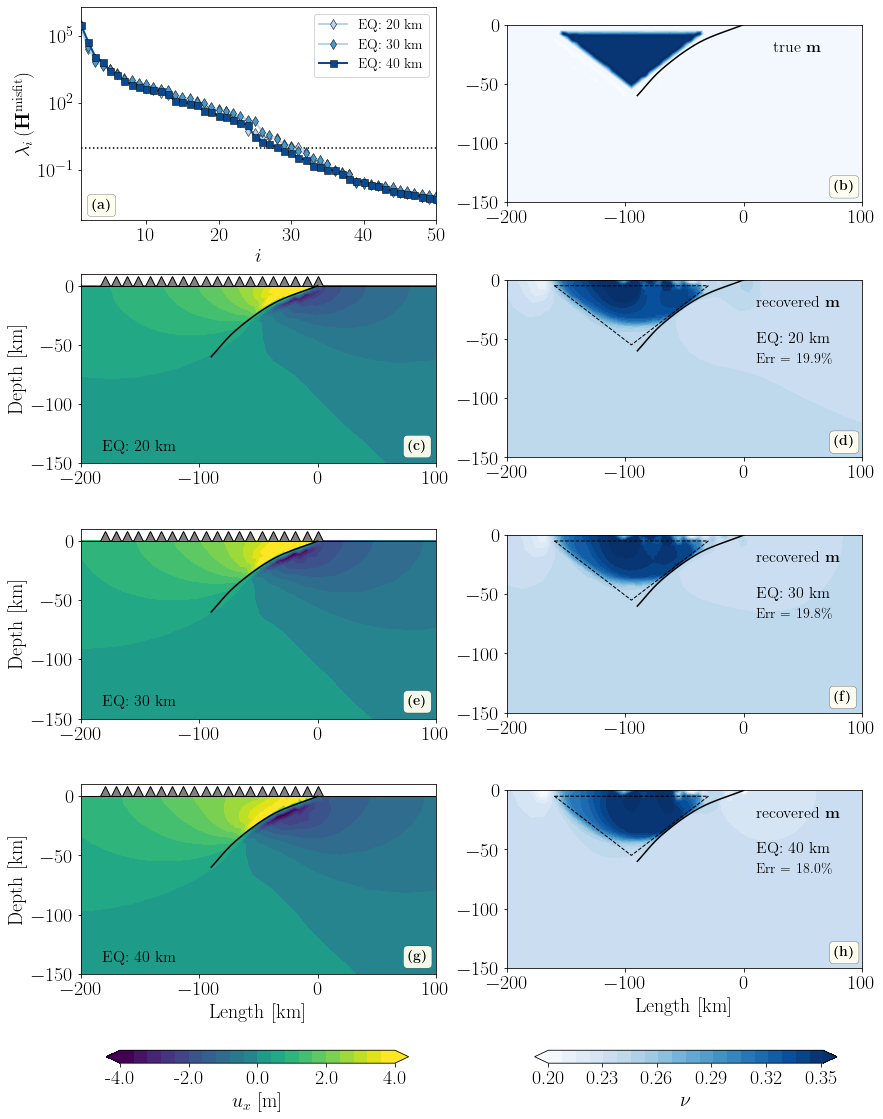

In [22]:
# Plot the results
fig = plt.figure(figsize=(14,18))
x_text, y_text = 10, -70

plt.subplot(4,2,1)
n_lmbda = 80
colors = [ cmap_1(0.3), cmap_1(0.6), cmap_1(0.9) ]
plt.plot(range(1, n_lmbda+1), np.ones(n_lmbda), linestyle="dotted", color="black", zorder=1)
plt.plot(range(1, n_lmbda+1), lmbda_R_1, marker="d", ls='solid', lw=2., color=colors[0],
         ms=7, mfc=colors[0], mec="black", mew=0.5, label=r"EQ: $20$ km", 
         zorder=1)
plt.plot(range(1, n_lmbda+1), lmbda_R_2, marker="d", ls='solid', lw=2., color=colors[0],
         ms=7, mfc=colors[1], mec="black", mew=0.5, label=r"EQ: $30$ km", 
         zorder=2)
plt.plot(range(1, n_lmbda+1), lmbda_R_3, marker="s", ls='solid', lw=2., color=colors[2],
         ms=7, mfc=colors[2], mec="black", mew=0.5, label=r"EQ: $40$ km", 
         zorder=3)
plt.legend(loc='best', fontsize=14)
plt.xlim((1, 50))
plt.ylim((6e-4, 2e6))
plt.yscale('log')
plt.xlabel(r"$i$")
plt.ylabel(r"$\lambda_i\, (\mathbf{H}^{\mathrm{misfit}})$")
ax = plt.gca()
ax.text(0.03, 0.1, r'\textbf{(a)}', transform=ax.transAxes, fontsize=TINY_SIZE, verticalalignment='top', 
        bbox=props)


# Plot true solution
plt.subplot(4,2,2)
pl = dl.plot( mtrue, levels=levels_m, cmap=cmap_1, extend='both')
plt.plot(xf, yf, 'k')
plt.xlim((lef, rig)); plt.ylim((bot, topp))
plt.axis('on');
ax = plt.gca()
ax.set_aspect('equal')
ax.text(0.92, 0.125, r'\textbf{(b)}', transform=ax.transAxes, fontsize=TINY_SIZE, verticalalignment='top', 
        bbox=props)
ax.text(0.75, 0.91, r"true $\mathbf{m}$", transform=ax.transAxes, fontsize=16, verticalalignment='top')


# Plot observations location. EQ: 20 km depth
plt.subplot(4,2,3)
pl = dl.plot(dl.Function(Vh[hp.STATE].sub(1), utrue_1)[0], levels=levels_ux, cmap=cmap_2, extend='both')
plt.plot([lef, rig], [0.0, 0.0], 'k', linewidth=1.0, zorder=3)
plt.plot(targets[:,0], targets[:,1]+4, marker="^", linestyle='None',
         markersize=10, markerfacecolor="grey", markeredgecolor="black")
plt.plot(xf, yf, 'k', zorder=2)
plt.xlim((lef, rig)); plt.ylim((bot, 10.0))
plt.ylabel("Depth [km]")
ax = plt.gca()
ax.set_aspect('equal')
ax.text(0.92, 0.125, r'\textbf{(c)}', transform=ax.transAxes, fontsize=TINY_SIZE, verticalalignment='top', 
        bbox=props)
ax.text(0.06, 0.125, r"EQ: $20$ km", transform=ax.transAxes, fontsize=16, verticalalignment='top')


# Plot calculated solution. EQ: 20 km depth
plt.subplot(4,2,4)
CS = dl.plot( m_1, levels=levels_m, cmap=cmap_1, extend='both')
plt.plot(xf, yf, 'k')
plt.text( x_text, y_text, r"Err = {:.1f}\%".format(rel_error_1), fontsize=TINY_SIZE )
plt.xlim((lef, rig)); plt.ylim((bot, topp))
plt.axis('on');
ax = plt.gca()
ax.add_patch(Polygon(xy_triangle, facecolor="None", edgecolor="black", linestyle="--"))
ax.set_aspect('equal')
ax.text(0.92, 0.125, r'\textbf{(d)}', transform=ax.transAxes, fontsize=TINY_SIZE, verticalalignment='top', 
        bbox=props)
ax.text(0.7, 0.91, r"recovered $\mathbf{m}$", transform=ax.transAxes, fontsize=16, verticalalignment='top')
ax.text(0.7, 0.71, r"EQ: $20$ km", transform=ax.transAxes, fontsize=16, verticalalignment='top')


# Plot observations location. EQ: 30 km depth
plt.subplot(4,2,5)
pl = dl.plot(dl.Function(Vh[hp.STATE].sub(1), utrue_2)[0], levels=levels_ux, cmap=cmap_2, extend='both')
plt.plot([lef, rig], [0.0, 0.0], 'k', linewidth=1.0, zorder=3)
plt.plot(targets[:,0], targets[:,1]+4, marker="^", linestyle='None',
         markersize=10, markerfacecolor="grey", markeredgecolor="black")
plt.plot(xf, yf, 'k', zorder=2)
plt.xlim((lef, rig)); plt.ylim((bot, 10.0))
plt.ylabel("Depth [km]")
ax = plt.gca()
ax.set_aspect('equal')
ax.text(0.92, 0.125, r'\textbf{(e)}', transform=ax.transAxes, fontsize=TINY_SIZE, verticalalignment='top', 
        bbox=props)
ax.text(0.06, 0.125, r"EQ: $30$ km", transform=ax.transAxes, fontsize=16, verticalalignment='top')


# Plot calculated solution. EQ: 30 km depth
plt.subplot(4,2,6)
CS = dl.plot( m_2, levels=levels_m, cmap=cmap_1, extend='both')
plt.plot(xf, yf, 'k')
plt.text( x_text, y_text, r"Err = {:.1f}\%".format(rel_error_2), fontsize=TINY_SIZE )
plt.xlim((lef, rig)); plt.ylim((bot, topp))
plt.axis('on');
ax = plt.gca()
ax.add_patch(Polygon(xy_triangle, facecolor="None", edgecolor="black", linestyle="--"))
ax.set_aspect('equal')
ax.text(0.92, 0.125, r'\textbf{(f)}', transform=ax.transAxes, fontsize=TINY_SIZE, verticalalignment='top', 
        bbox=props)
ax.text(0.7, 0.91, r"recovered $\mathbf{m}$", transform=ax.transAxes, fontsize=16, verticalalignment='top')
ax.text(0.7, 0.71, r"EQ: $30$ km", transform=ax.transAxes, fontsize=16, verticalalignment='top')


# Plot observations location
plt.subplot(4,2,7)
pl = dl.plot(dl.Function(Vh[hp.STATE].sub(1), utrue_3)[0], levels=levels_ux, cmap=cmap_2, extend='both')
plt.plot([lef, rig], [0.0, 0.0], 'k', linewidth=1.0, zorder=3)
plt.plot(targets[:,0], targets[:,1]+4, marker="^", linestyle='None',
         markersize=10, markerfacecolor="grey", markeredgecolor="black")
plt.plot(xf, yf, 'k', zorder=2)
plt.xlim((lef, rig)); plt.ylim((bot, 10.0))
plt.xlabel("Length [km]")
plt.ylabel("Depth [km]")
ax = plt.gca()
ax.set_aspect('equal')
ax.text(0.92, 0.125, r'\textbf{(g)}', transform=ax.transAxes, fontsize=TINY_SIZE, verticalalignment='top', 
        bbox=props)
ax.text(0.06, 0.125, r"EQ: $40$ km", transform=ax.transAxes, fontsize=16, verticalalignment='top')


# Plot calculated solution. EQ: 40 km depth
plt.subplot(4,2,8)
CS = dl.plot( m_3, levels=levels_m, cmap=cmap_1, extend='both')
plt.plot(xf, yf, 'k')
plt.text( x_text, y_text, r"Err = {:.1f}\%".format(rel_error_3), fontsize=TINY_SIZE )
plt.xlim((lef, rig)); plt.ylim((bot, topp))
plt.xlabel("Length [km]")
plt.axis('on');
ax = plt.gca()
ax.add_patch(Polygon(xy_triangle, facecolor="None", edgecolor="black", linestyle="--"))
ax.set_aspect('equal')
ax.text(0.92, 0.125, r'\textbf{(h)}', transform=ax.transAxes, fontsize=TINY_SIZE, verticalalignment='top', 
        bbox=props)
ax.text(0.7, 0.91, r"recovered $\mathbf{m}$", transform=ax.transAxes, fontsize=16, verticalalignment='top')
ax.text(0.7, 0.71, r"EQ: $40$ km", transform=ax.transAxes, fontsize=16, verticalalignment='top')

# Make a new Axes instance [left, bottom, width, height]
cbar_ax2 = plt.gcf().add_axes([0.575, 0.065, 0.3, 0.01])
cbar = plt.colorbar( CS, cax=cbar_ax2, orientation="horizontal",
                    ticks=[0.2, 0.23, 0.26, 0.29, 0.32, 0.35],
                    format="%.2f", label=r'$\mathrm{\nu}$' )
cbar.ax.xaxis.set_ticks_position('bottom')
cbar.ax.xaxis.set_label_position('bottom')

# Make a new Axes instance [left, bottom, width, height]
cbar_ax1 = plt.gcf().add_axes([0.15, 0.065, 0.3, 0.01])
cbar = plt.colorbar(pl, cax=cbar_ax1, orientation="horizontal", format="%.1f",
                    ticks=[-4., -2., 0., 2., 4.],
                    label=r'$u_x$ [m]')
cbar.ax.xaxis.set_ticks_position('bottom')
cbar.ax.xaxis.set_label_position('bottom')


plt.show()

In [44]:
# Save it as pandas dataframe
tosave = pd.DataFrame(lmbda_all.T, columns=['5', '10', '15', '20', '25', 
                                            '30', '35', '40', '45', '50', 
                                            '55', '60'])

if False:
    savepath = "../Figures/"
    outFileName = 'eigenvalues_EQdepth_mu_nu.txt'
    tosave.to_csv(savepath + outFileName, sep=' ', index=False)
